![EncabezadoIN](EncabezadoIN.JPG)

## Laboratorio 2 - Regresión

Integrantes: 
Juan Pablo Lora Hernández - 202012524 

Andrés Francisco Borda Rincón - 201729184

Gabriela Vargas Rojas - 202013830


## Caso 
CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con determinar el precio adecuado para un portatil ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.
Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

## 1. Carga de librerías necesarias para implementación

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

import scipy.stats as stats

## 2. Cargar los datos

In [2]:
# Se cargan los datos de entrenamiento.
df_compu=pd.read_csv('./Regresión_data_laptop_data_train.csv', sep=',', encoding = "ISO-8859-1")

## 3. Entendimiento de los datos 

Al explorar los datos encontramos que nos dieron registros de 1216 computadores que se han venido en la tienda minorista de CompuAlpes de diferentes fabricantes y especificaciones técnicas. Cada registro cuenta con 14 columnas de las cuales 7 son numéricas y 7 son categóricas. De estas, 1 columna nos sirve para identificar cada uno de manera única, 10 nos dan información sobre las características o especificaciones técnicas sobre los computadores y las últimas 3 nos dan informacion sobre los fabricantes involucrados en diferentes componentes de estos.

Respecto al diccionario de datos proporcionado, este no contiene los rangos de valores que pueden manejar las variables númericas por ende se hace más díficil el análisis en términos de validez.
Aún así, se realizan los respecrtivos analisis estadisticos de variables númericas.

In [3]:
df_compu.shape

(1216, 14)

In [4]:
df_compu.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [5]:
df_compu.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
205,95,Acer,2 in 1 Convertible,8,1.50,10.717262,1,1,165.632118,Intel Core i5,0.0,256,Intel,Windows
539,247,Asus,Gaming,16,3.60,11.981595,0,0,127.335675,Intel Core i7,0.0,256,Nvidia,Windows
842,103,HP,Ultrabook,8,1.38,222.239809,0,1,165.632118,Intel Core i7,0.0,256,Nvidia,Windows
1126,1081,Lenovo,Gaming,32,4.60,12.058890,0,1,127.335675,Intel Core i7,0.0,512,Nvidia,Windows
1083,744,Lenovo,Workstation,16,2.50,12.076936,0,1,282.423996,Intel Core i7,0.0,1000,Nvidia,Windows


In [6]:
#Analisis estadistico de las variables numericas
df_compu_num = df_compu[['id', 'Ram', 'Weight', 'Ppi', 'HDD', 'SSD', "Price"]].copy()
df_compu_num.describe()

,id,Ram,Weight,Ppi,HDD,SSD,Price
count,1216.000000,1216.000000,1193.000000,1204.000000,1200.000000,1216.000000,1201.000000
mean,637.925164,8.458882,2.401572,183.830716,441.218800,187.529605,13.114402
std,367.482876,5.094332,4.844791,449.708876,927.052855,186.902926,28.659102
min,0.000000,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,319.750000,4.000000,1.500000,127.335675,0.000000,0.000000,10.403650
50%,638.500000,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,954.250000,8.000000,2.320000,157.350512,1000.000000,256.000000,11.288115
max,1272.000000,64.000000,97.729949,7328.468865,24127.543112,1024.000000,499.766079


## 4. Analisis de calidad de los datos

### 4.1 Completitud

In [7]:
#Sacamos las variables candidatas
features = ["Company", "TypeName", "Ram", "Weight", "TouchScreen", "Ips", "Ppi", "Cpu_brand", "HDD", "SSD", "Gpu_brand", "Os"]

In [8]:
#Analizamos la completitud de los datos
df_compu[["Price"]+features].isnull().sum() / df_compu.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

### 4.2 Unicidad

In [9]:
#Se revisa si hay registros duplicados
df_compu.duplicated(keep = False).sum()

10

### 4.3 Consistencia

In [10]:
# Se revisa la variable TypeName
df_compu.TypeName.value_counts()

Notebook                656
Gaming                  189
Ultrabook               187
2 in 1 Convertible      109
Workstation              29
Netbook                  21
Notebook%%                9
&&Notebook                5
Gaming%%                  4
&&Gaming                  3
&&2 in 1 Convertible      2
2 in 1 Convertible%%      1
&&Ultrabook               1
Name: TypeName, dtype: int64

In [11]:
# Se revisa la variable GPU Brand
df_compu.Gpu_brand.value_counts()

Intel       662
Nvidia      371
AMD         166
Intel%%       6
Nvidia%%      6
&&Intel       2
&&Nvidia      1
AMD%%         1
&&AMD         1
Name: Gpu_brand, dtype: int64

Dado que no se dieron posibles valores en el diccionario de datos para las variables numericas estas no pueden ser revisadas.

### 4.4 Validez

Se reviso la validez de cada columna y no se encontraron valores fuera de lo normal para ninguna. Esto puede ser evidenciado en que en la carga de los datos todas las columnas son del datatype esperado. Adicionalmente, se cargaron los datos en la herramienta Power BI y no se encontro errores en ninguna columna.

## 5. Perfilamiento de datos

In [12]:
#import pandas_profiling

#profiling =pandas_profiling.ProfileReport(df_compu)
#profiling

## 6. Preparación de los datos 

### 6.1 Correción de los datos

In [13]:
#Eliminar las filas con valores nulos
df_compu_prep = df_compu.dropna()
df_compu_prep[["Price"]+features].isnull().sum() / df_compu_prep.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

In [14]:
# Eliminar registros duplicados y quedarse con uno de cada conjunto de duplicados
#Problema de duplicidad
df_compu_prep.drop_duplicates(inplace=True)
#Se revisa si hay registros duplicados
df_compu_prep.duplicated(keep = False).sum()


C:\Users\andre\AppData\Local\Temp\ipykernel_7208\3772055880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep.drop_duplicates(inplace=True)


0

In [15]:
#Problema de consistencia columna (TypeName)
def corregir_TypeName(variacion):
    if variacion in ["Notebook%%", "&&Notebook"]:
        return "Notebook"
    elif variacion in ["Gaming%%", "&&Gaming"]:
        return "Gaming"
    elif variacion in ["&&2 in 1 Convertible", "2 in 1 Convertible%%"]:
        return "2 in 1 Convertible"
    elif variacion in ["&&Ultrabook"]:
        return "Ultrabook"
    else:
        return variacion

# Aplicar la función a la columna titleType
df_compu_prep['TypeName'] = df_compu_prep['TypeName'].apply(corregir_TypeName)

# Verificar nuevamente la variable titleType después de corregir
df_compu_prep.TypeName.value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_7208\3083795587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep['TypeName'] = df_compu_prep['TypeName'].apply(corregir_TypeName)


Notebook              644
Gaming                192
Ultrabook             177
2 in 1 Convertible    106
Workstation            28
Netbook                19
Name: TypeName, dtype: int64

In [16]:
# Se revisa la variable TypeName
df_compu.Gpu_brand.value_counts()

Intel       662
Nvidia      371
AMD         166
Intel%%       6
Nvidia%%      6
&&Intel       2
&&Nvidia      1
AMD%%         1
&&AMD         1
Name: Gpu_brand, dtype: int64

In [17]:
#Problema de consistencia columna (Gpu_brand)
def corregir_Gpu_brand(variacion):
    if variacion in ["Intel%%", "&&Intel"]:
        return "Intel"
    elif variacion in ["Nvidia%%", "&&Nvidia"]:
        return "Nvidia"
    elif variacion in ["&&AMD", "AMD%%"]:
        return "AMD"
    else:
        return variacion

# Aplicar la función a la columna titleType
df_compu_prep['Gpu_brand'] = df_compu_prep['Gpu_brand'].apply(corregir_Gpu_brand)

# Verificar nuevamente la variable titleType después de corregir
df_compu_prep.Gpu_brand.value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_7208\441937007.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compu_prep['Gpu_brand'] = df_compu_prep['Gpu_brand'].apply(corregir_Gpu_brand)


Intel     637
Nvidia    369
AMD       160
Name: Gpu_brand, dtype: int64

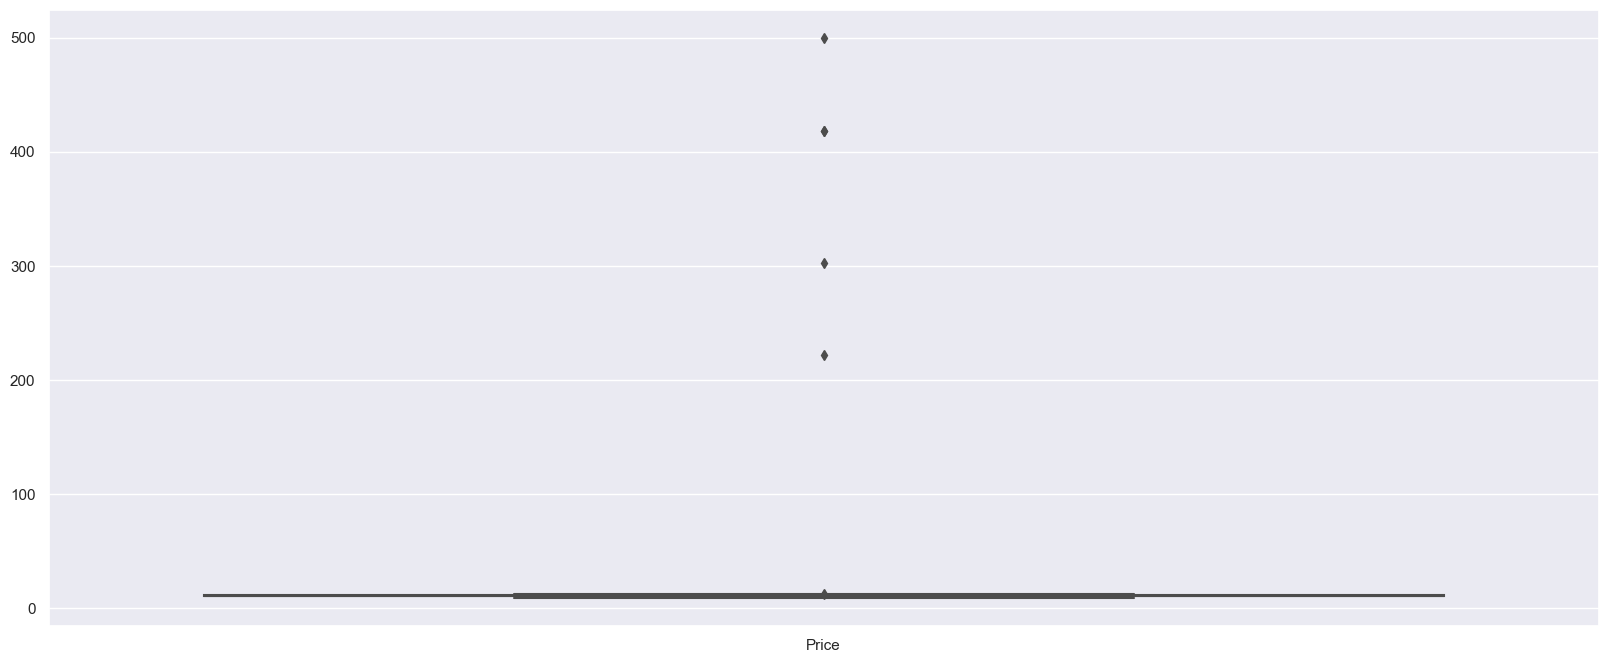

In [18]:
# Analizar valores atipicos en la variable de interes

df_compu_prep_var = df_compu_prep[['Price']].copy()
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_compu_prep_var, orient ="v")

In [19]:
df_compu_prep.Price.describe()

count    1166.000000
mean       12.385126
std        24.476793
min         9.134616
25%        10.402328
50%        10.882316
75%        11.288115
max       499.766079
Name: Price, dtype: float64

In [20]:
#Eliminar los outliers price
Q1 = df_compu_prep['Price'].quantile(0.25)
Q3 = df_compu_prep['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_compu_prep = df_compu_prep[(df_compu_prep['Price'] >= lower_bound) & (df_compu_prep['Price'] <= upper_bound)]

In [21]:
df_compu_prep.Price.describe()

count    1160.000000
mean       10.834512
std         0.617662
min         9.134616
25%        10.398402
50%        10.882316
75%        11.287614
max        12.587883
Name: Price, dtype: float64

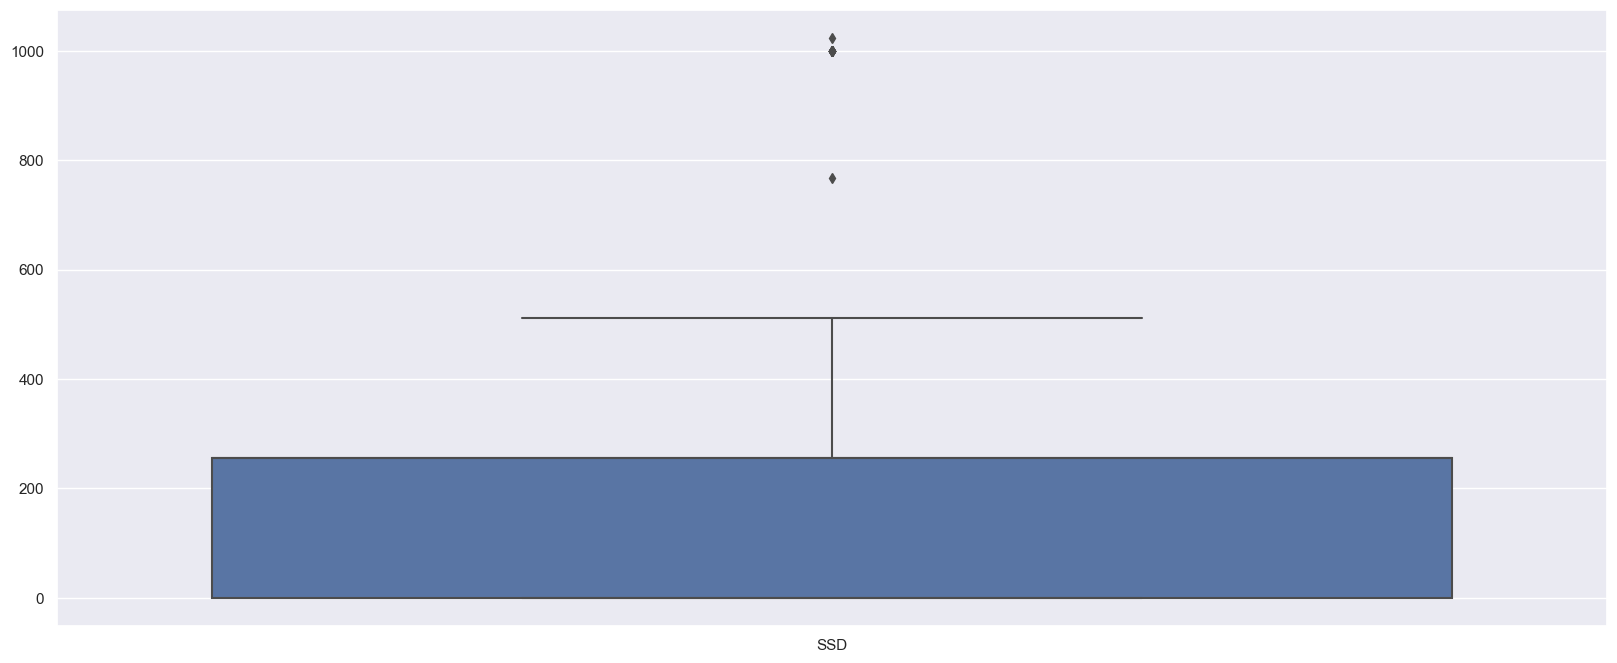

In [22]:
# Analizar valores atipicos en la variable SSD

df_compu_prep_var = df_compu_prep[['SSD']].copy()
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_compu_prep_var, orient ="v")

In [23]:
#Eliminar los outliers price
Q1 = df_compu_prep['SSD'].quantile(0.25)
Q3 = df_compu_prep['SSD'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_compu_prep = df_compu_prep[(df_compu_prep['SSD'] >= lower_bound) & (df_compu_prep['SSD'] <= upper_bound)]

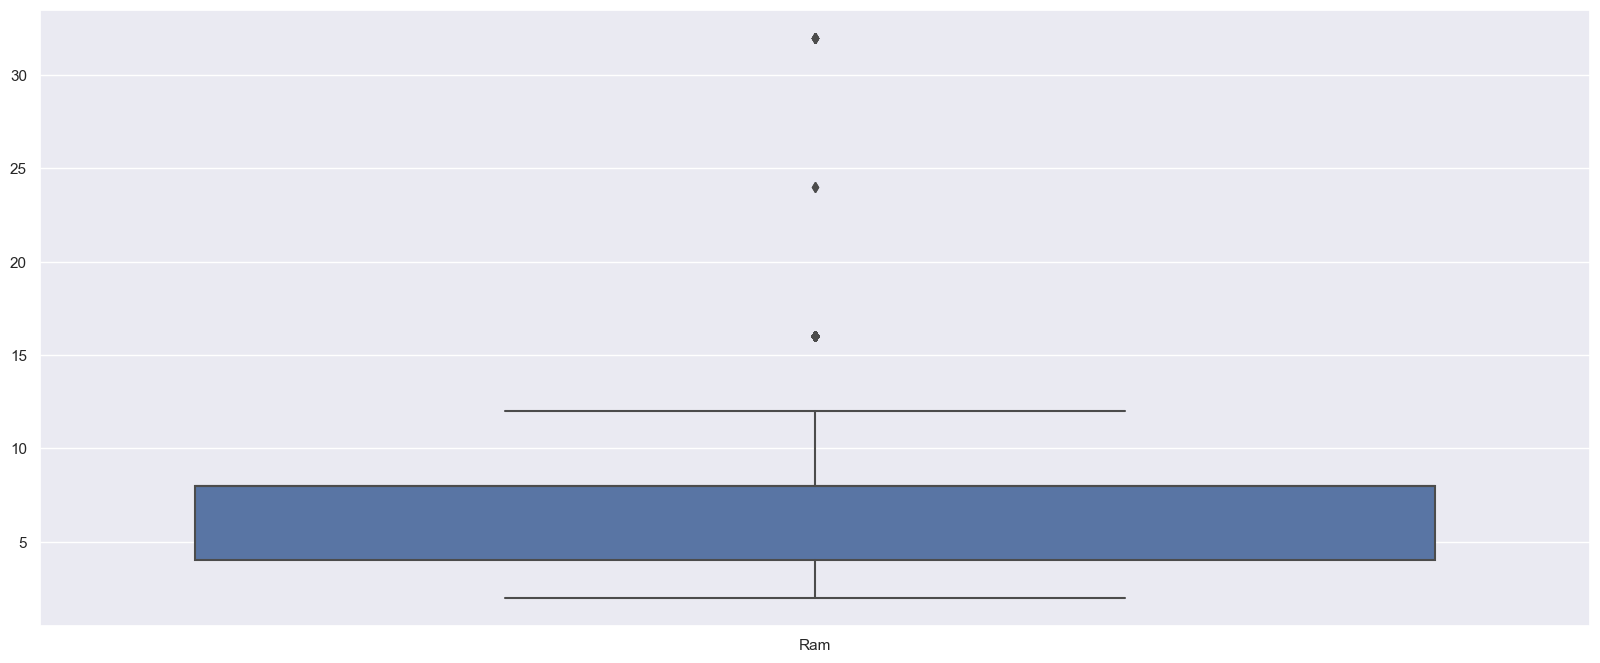

In [24]:
# Analizar valores atipicos en la variable RAM

df_compu_prep_var = df_compu_prep[['Ram']].copy()
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_compu_prep_var, orient ="v")

In [25]:
#Eliminar los outliers price
Q1 = df_compu_prep['Ram'].quantile(0.25)
Q3 = df_compu_prep['Ram'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_compu_prep = df_compu_prep[(df_compu_prep['Ram'] >= lower_bound) & (df_compu_prep['Ram'] <= upper_bound)]

In [26]:
#Sacamos las variables numericas y categoricas
features_num = ["Ram", "Weight", "Ppi", "HDD", "SSD"]
features_cat = ["Company", "TypeName", "TouchScreen", "Ips", "Cpu_brand", "Gpu_brand", "Os"]

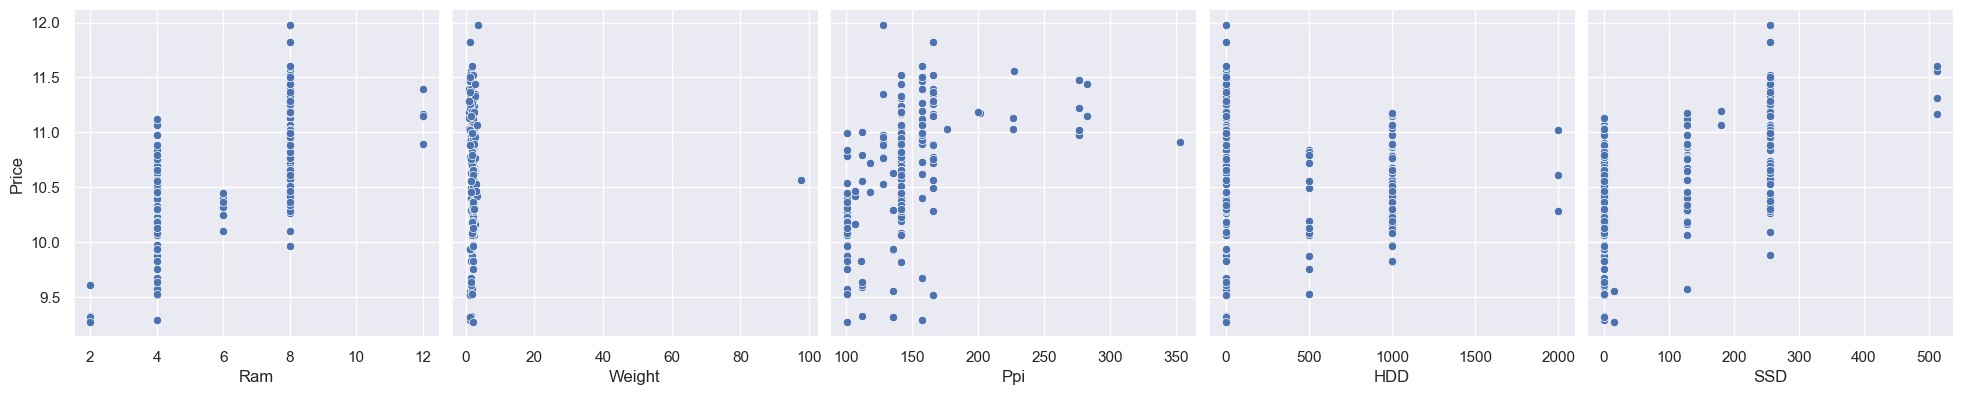

In [27]:
#Relación de la variable objetivo con las demas variables
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars=features_num, kind="scatter")

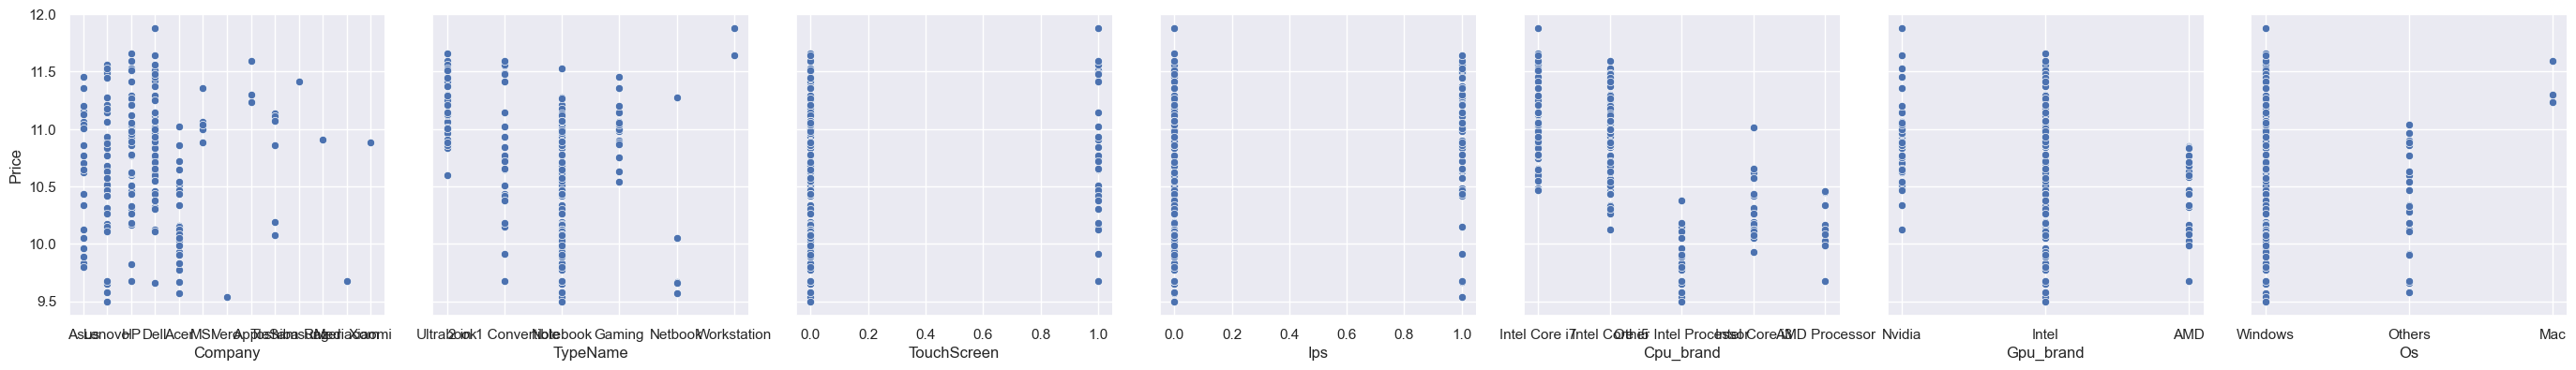

In [28]:
#Relación de la variable objetivo con las demas variables
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars=features_cat, kind="scatter")

<AxesSubplot:>

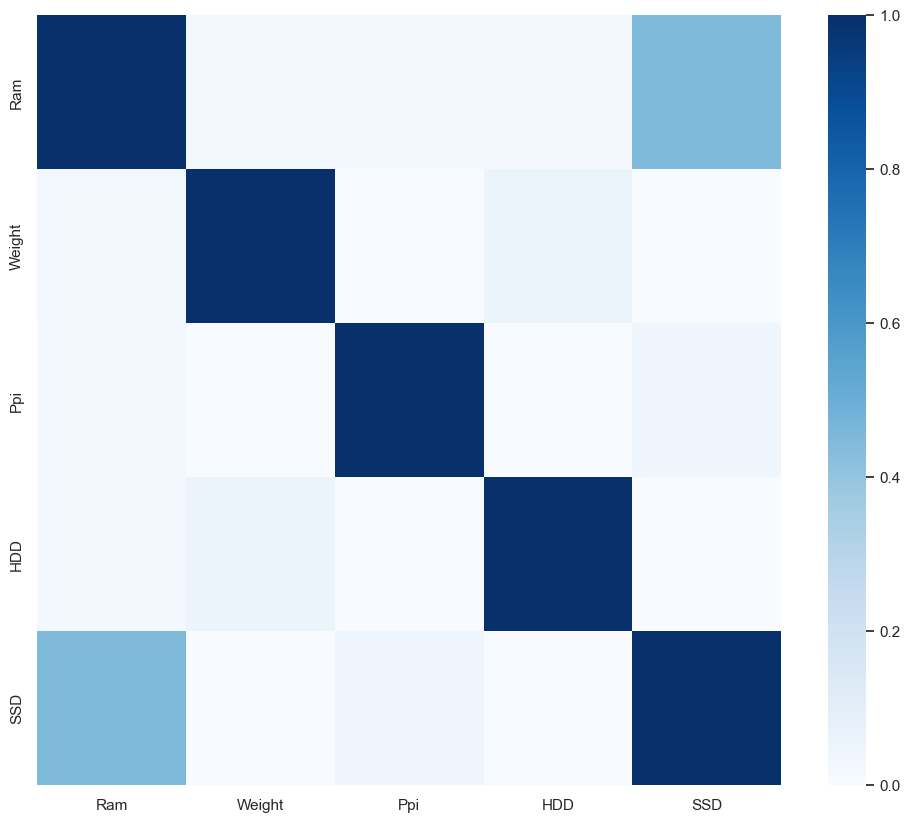

In [29]:
# Correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(df_compu_prep[features_num].corr(), cmap="Blues", vmin=0, vmax=1)

In [30]:
#Pasar la variable procesador a numerica utilizando label encoder
label_encoder = LabelEncoder()
custom_order = {'Other Intel Processor': 0, 'AMD Processor': 1, 'Intel Core i3': 2, 'Intel Core i5': 3, 'Intel Core i7': 4}

df_compu_prep['Cpu_brand_encoded'] = df_compu_prep['Cpu_brand'].map(custom_order)
df_compu_prep.Cpu_brand.value_counts()

Intel Core i5            376
Intel Core i7            283
Intel Core i3            124
Other Intel Processor    119
AMD Processor             53
Name: Cpu_brand, dtype: int64

In [31]:
df_compu_prep.Ram.value_counts()

8     556
4     329
6      33
12     24
2      13
Name: Ram, dtype: int64

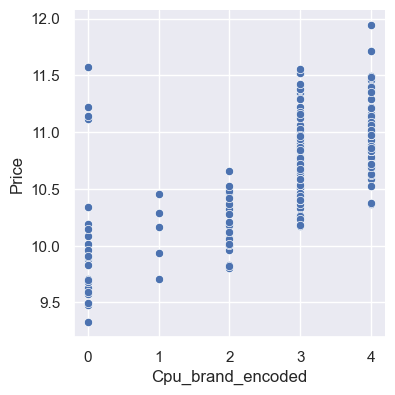

In [32]:
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars="Cpu_brand_encoded", kind="scatter")

In [33]:
#Pasar la variable Ram a categorica
custom_order = {2: 0, 4: 1, 6: 2, 8: 3, 12: 4, 16: 5, 24: 6, 32: 7, 64: 8}

df_compu_prep['Ram_encoded'] = df_compu_prep['Ram'].map(custom_order)
df_compu_prep.Ram.value_counts()

8     556
4     329
6      33
12     24
2      13
Name: Ram, dtype: int64

In [34]:
df_compu_prep.Ram_encoded.value_counts()

3    556
1    329
2     33
4     24
0     13
Name: Ram_encoded, dtype: int64

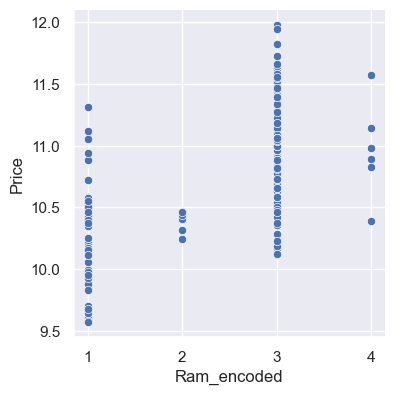

In [35]:
sns.pairplot(df_compu_prep.sample(frac=0.2), height=4, y_vars="Price", x_vars="Ram_encoded", kind="scatter")

## 7. Entrenamiento del modelo

### 7.1 Selección de variables

In [36]:
#Se copian las variables a utilizar
var_selec = ["Cpu_brand_encoded", "Ram_encoded"]
#df_compu_model_X = df_compu_prep[var_selec].copy()
#df_compu_model_Y = df_compu_prep["Price"].copy()
X_train, X_test, y_train, y_test = train_test_split(df_compu_prep[var_selec], df_compu_prep["Price"], test_size=0.3, random_state=1)

In [37]:
X_train.shape, y_train.shape

((668, 2), (668,))

In [38]:
X_test.shape, y_test.shape

((287, 2), (287,))

In [39]:
# Vamos a llevar al mismo dominio las diferentes variables
mms= StandardScaler()
# transform data
df_compu_Xnorm = mms.fit_transform(X_train[var_selec])
df_compu_model_X = pd.DataFrame(df_compu_Xnorm, columns =var_selec)

In [40]:
df_compu_model_X.head()

,Cpu_brand_encoded,Ram_encoded
0,1.010577,0.741565
1,1.010577,0.741565
2,-1.327987,1.740286
3,0.231056,0.741565
4,0.231056,0.741565


### 7.2 Entrenamiento del modelo

In [41]:
# Se entrena el modelo con los datos de entrenamiento elegidos
regression = LinearRegression()
regression.fit(df_compu_model_X, y_train)

LinearRegression()

In [42]:
pd.DataFrame({"columns": var_selec, "coef": regression.coef_})

,columns,coef
0,Cpu_brand_encoded,0.244171
1,Ram_encoded,0.241172


In [43]:
regression.intercept_

10.687271515042566

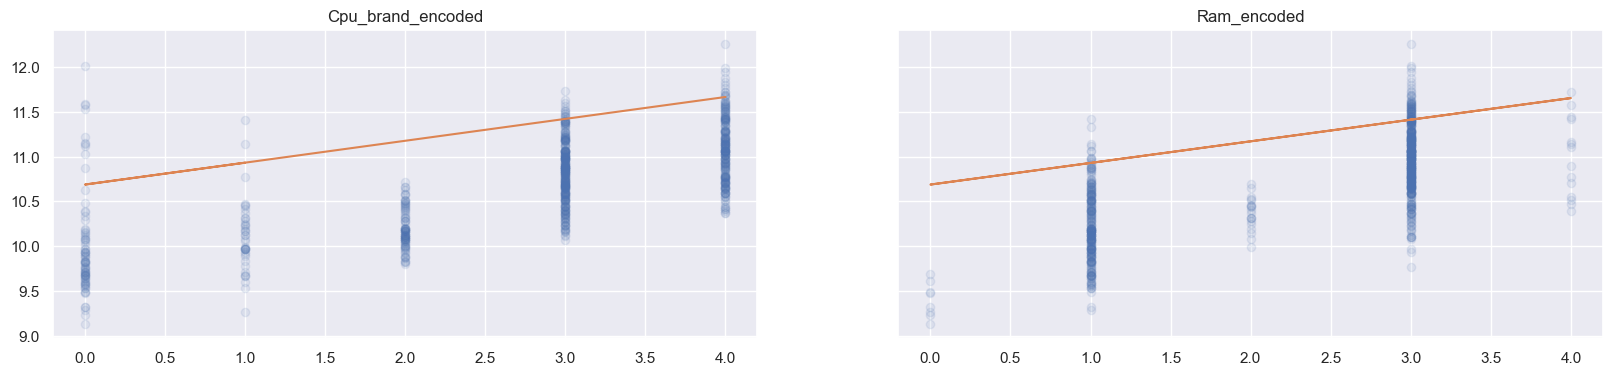

In [44]:
f, axs = plt.subplots(1, len(var_selec), sharey=True, figsize=(20, 4))

for i in range(len(var_selec)):
    col = var_selec[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

## 8. Validación del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [45]:
# Calculo del error MAE
print("Train:", mean_absolute_error(y_train, regression.predict(df_compu_model_X)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.27021381244581744
Test: 1.211000082417069


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [46]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(df_compu_model_X))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.3460508761681018
Test: 1.2633176949982532


**Análisis del error**

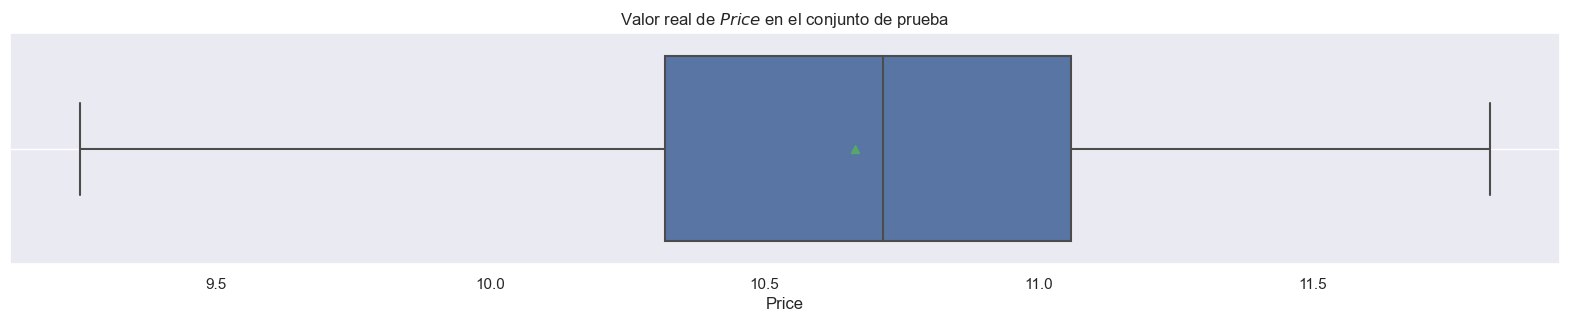

In [47]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Price}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [48]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    287.000000
mean      10.665653
std        0.549914
min        9.253676
25%       10.319441
50%       10.717262
75%       11.060617
99%       11.652144
max       11.822933
Name: Price, dtype: float64

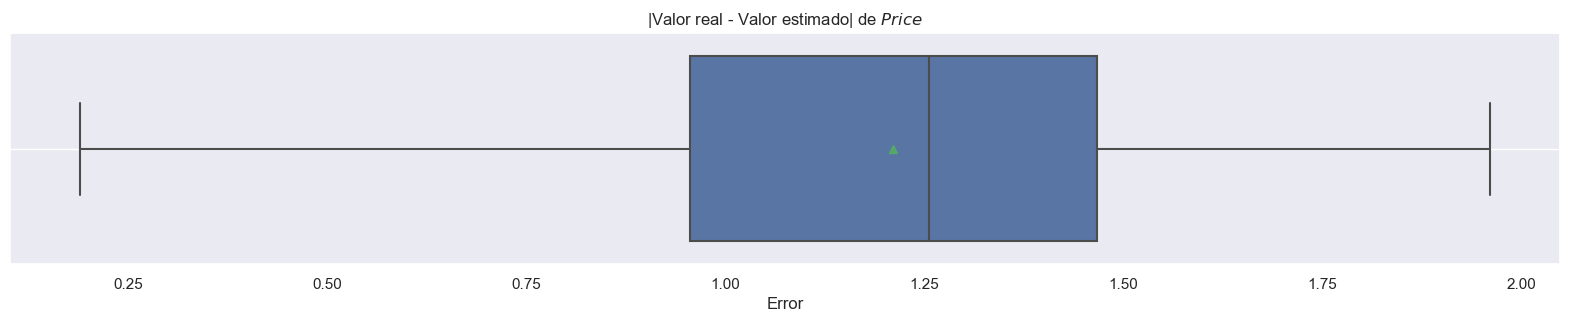

In [49]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Price}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [50]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    287.000000
mean       1.211000
std        0.360421
min        0.190411
25%        0.955878
50%        1.255789
75%        1.466852
95%        1.788807
99%        1.921177
max        1.959991
Name: Price, dtype: float64

## 9. Supuestos

### 9.1. Colinealidad

<AxesSubplot:>

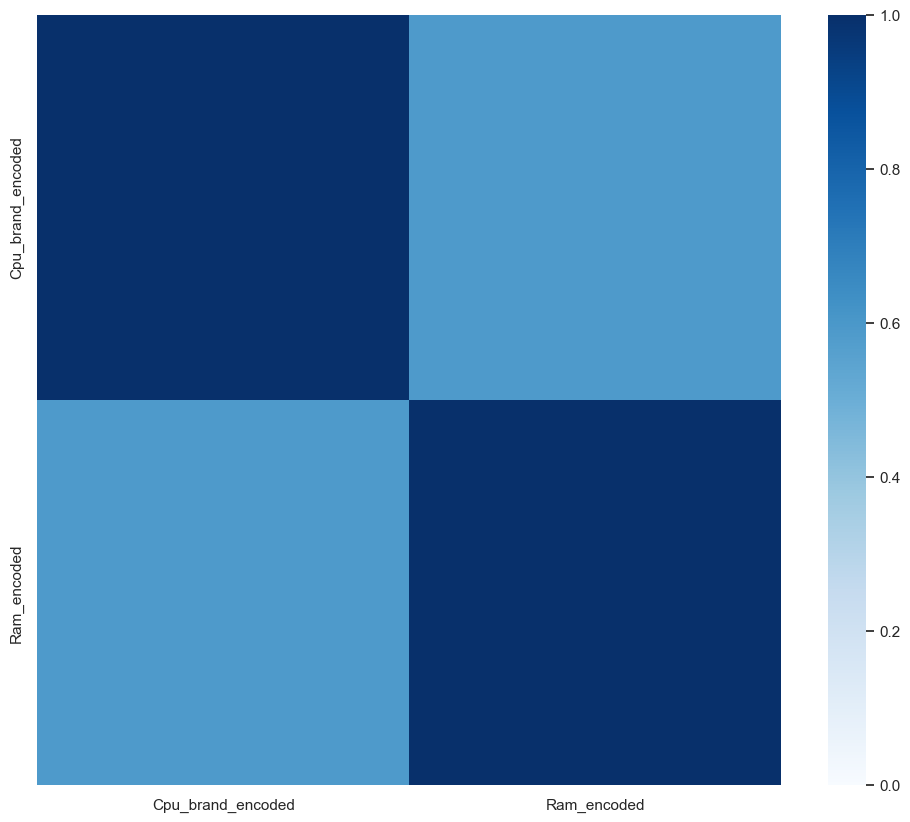

In [51]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [52]:
X_train.corr()

,Cpu_brand_encoded,Ram_encoded
Cpu_brand_encoded,1.000000,0.586203
Ram_encoded,0.586203,1.000000


Se puede ver en la gráfica que las variables tienen una relación, sin embargo, el coeficiente es de 0,5862 lo cual indica que es baja y se pueden usar.

### 9.2. Linealidad

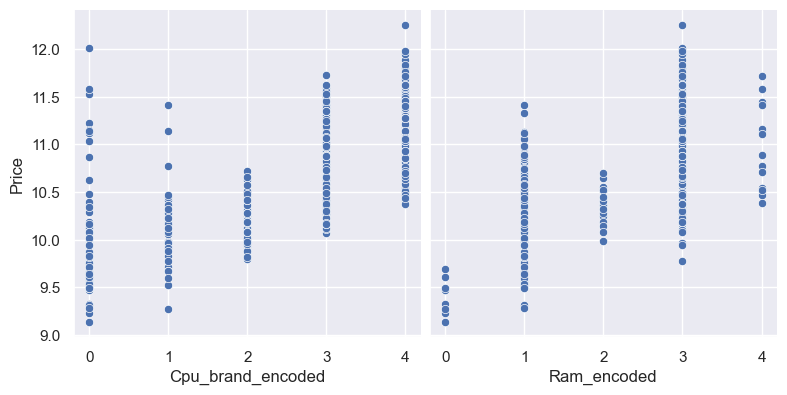

In [53]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="Price", x_vars=var_selec, kind="scatter")

Como podemos observar la relación de las variables elegidas con la variable objetivo es lineal por lo que se cumple el supuesto.

### 9.3. Normalidad de Errores

In [54]:
errors = (regression.predict(X_train[var_selec])-y_train).values

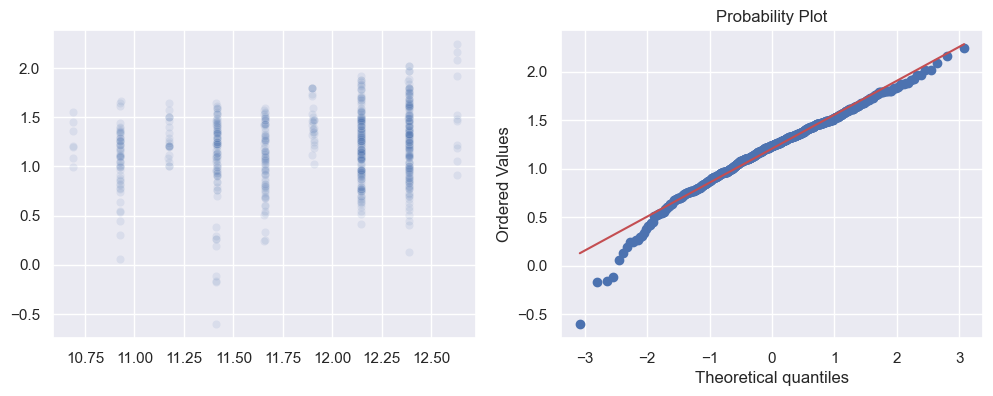

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=regression.predict(X_train[var_selec]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Podemos observar en la grafica qq-plot como la distribución de los errores se ajusta bien a la distribución normal por lo que se cumple el supuesto de normalidad de los errores.

### 9.4. Homocedasticidad

<AxesSubplot:>

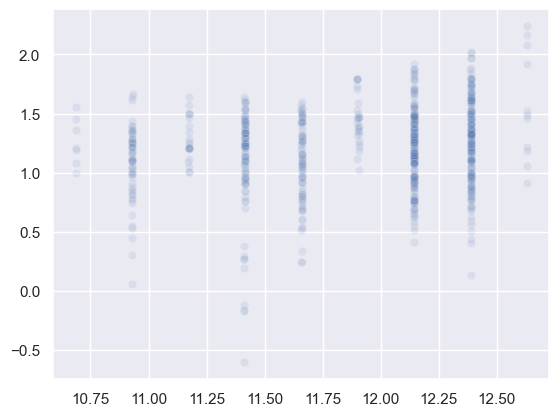

In [56]:
sns.scatterplot(x = regression.predict(X_train[var_selec]), y=errors, alpha=0.1)

En la distribución se puede ver que no existe un problema de heterocedasticidad.

## 10. Pipeline

In [57]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

## 11. Predicción de valores

In [58]:
#Importar datos a predecir
df_compu_predict=pd.read_csv('./Regresión_data_laptop_data_test_unlabeled.csv', sep=',', encoding = "ISO-8859-1")

In [59]:
#Preparar la variable Ram para el calculo
custom_order = {2: 0, 4: 1, 6: 2, 8: 3, 12: 4, 16: 5, 24: 6, 32: 7, 64: 8}

df_compu_predict['Ram_encoded'] = df_compu_predict['Ram'].map(custom_order)

In [60]:
#Preparar la variable procesador para el calculo
label_encoder = LabelEncoder()
custom_order = {'Other Intel Processor': 0, 'AMD Processor': 1, 'Intel Core i3': 2, 'Intel Core i5': 3, 'Intel Core i7': 4}

df_compu_predict['Cpu_brand_encoded'] = df_compu_predict['Cpu_brand'].map(custom_order)

In [61]:
#Se utiliza el modelo para predecir los precios de interes.
X_predict = df_compu_predict[var_selec]

df_compu_predict.CalculatedPrice = regression.predict(X_predict)

In [62]:
df_compu_predict.to_csv('resultado_prediccion.csv', index=False)